## 08. 2.11 Nonlinear Poisson equation, pp58

### Residue and Jacobian matrix
* 고전적인 전자 분포를 고려할 때, 평형 상태에서의 반도체 소자 내부의 electrostatic potential과 전자 농도 그리고 홀 농도를 구하는 올바른 방법을 배운다.
* 이산화가 이루어지고 난 후 실리콘 영역에 속하는 $x=x_i$인 점에 해당하는 Poisson 방정식은 다음과 같다.
  $$\frac{d}{dx}\left[\epsilon(x)\frac{d}{dx}\phi(x) \right]=-qp(x)+qn(x)-qN_{dop}^+(x)$$
  $$n(r) = n_i exp\left(\frac{\phi}{V_T} \right),\quad p(r) = n_i exp\left(-\frac{\phi}{V_T} \right) $$
  $$\frac{\epsilon_{si}}{\Delta x}(\phi_{i+1}-2\phi_i+\phi_{i-1})=-(\Delta x)qN_{dop}^+ +(\Delta x)qn_i exp\left(\frac{q \phi_i}{k_BT} \right)-(\Delta x)qn_i exp\left(-\frac{q \phi_i}{k_BT} \right) $$
* 마지막 홀 농도 무시
* In silicon regions, consider the integrated Poisson equation
  - Ax=b, Ax-b=0, f=r=Ax-b, J=df/dx, Jdphi=r
  - The i-th entry of the residue vector reads
  - self consistent로 전자농도는 update 되어야 한다.
  $$r_i=\frac{\epsilon_{si}}{\Delta x}(\phi_{i+1}-2\phi_i+\phi_{i-1})-(\Delta x)qN_{acc}-\textcolor{red}{(\Delta x)qn_i exp\left(\frac{q \phi_i}{k_BT} \right)}$$
  - residue 벡터 성분인 함수 $r_i$가 결정되고 나면, 이를 편미분하여서 Jacobian 행렬의 성분들도 구할 수 있다. 
  - The i-th row of the jacobian matrix reads $J_{i,j}$
  $$J_{i,i+1}=\frac{\epsilon_{si}}{\Delta x} $$
  $$J_{i,i}=-2\frac{\epsilon_{si}}{\Delta x}-\textcolor{red}{(\Delta x)qn_i\frac{q}{k_B T}exp\left(\frac{q\phi_i}{k_B T} \right)} $$
  $$J_{i,i-1}=\frac{\epsilon_{si}}{\Delta x} $$
  - 위의 세가지 성분들 중에서 실제로 electrostatic potential에 따라 바뀌는 것은 $J_{i,i}$ 밖에 없다. 이 성분 때문에 전체 시스템이 비선형성을 가지게 되므로, Jacobian 행렬은 Newton-Raphson loop가 수행될 때마다 적절하게 고려가 되어야 한다.
  - 경계가 아닌 산화막 영역에 대해서는 residue 함수가 필요.
    $$r_i=\frac{\epsilon_{ox}}{\Delta x}(\phi_{i+1}-2\phi_i+\phi_{i-1})$$
  - 불순물이나 전자 농도 등에 의한 기여분이 없으므로 실리콘 영역보다 훨씬 간단하다.
  - 실리콘-산화막 경계에 대한 특별한 처리가 필요하다. 미분연산자에 어렵지 않을 것이지만, 불순물이나 전자 농도에 대해서는 언급이 필요할 것이다. $\Delta x$ 길이를 가지고 있는 구간에 대해 적분된 Poisson 방정식이므로, 구간의 반은 실리콘이고 다른 반은 산화막에 속할 것이다. 불순물과 전자 농도에 곱해지는 길이가 $\Delta x$가 아닌 그 값의 반이 될 것이다.
    $$r_i=\frac{\epsilon_{i+0.5}}{\Delta x}(\phi_{i+1}-\phi_i)-\frac{\epsilon_{i-0.5}}{\Delta x}(\phi_i-\phi_{i-1})+\frac{\Delta x}{2}qN_{dop}^+ - \frac{\Delta x}{2}qn_{int}exp\left(\frac{q\phi_i}{k_BT} \right) $$
### Python
* Defining variables
* Jaco and res should be constructed.
  - Boundary conditions
* Laplacian part
* Charge part
* Full code
### Problem
* Write the nonlinear Poisson solver for the double-gate structure.
* The oxide thickness is 0.8um
* Calcuate the integrated electron density as a function of the gate voltage(use the self-consistent solution)
* Vg from 0 to 1V

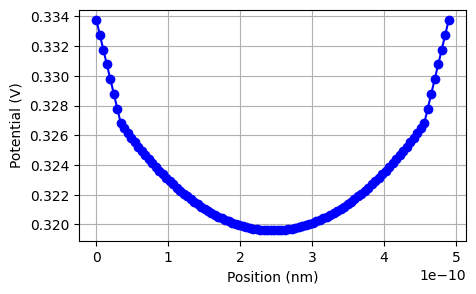

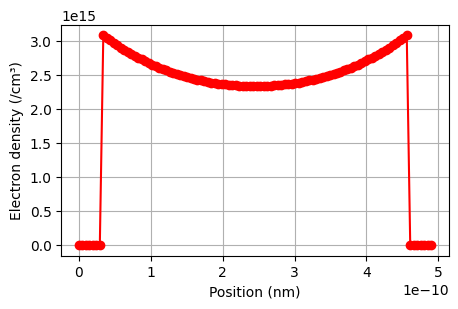

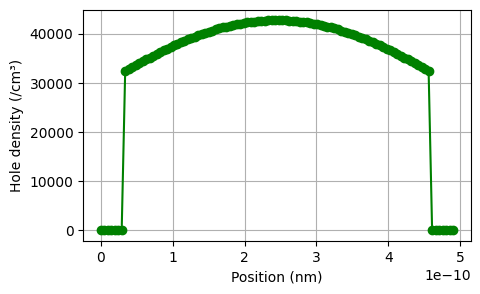

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

#### Variable ####
t1 = 0.5e-9  # Oxide thickness, m
t2 = 6e-9  # Silicon thickness, m
N = 101
Ndop = -1e18*1e6 # Doping concentration, 1/m^3

# Constants
q = 1.602192e-19
epsilon0 = 8.854187817e-12
nint = 1e16  # Intrinsic carrier concentration (1/cm^3)
kB = 1.38065e-23  # Boltzmann constant (J/K)
T = 300.0  # Temperature (K)
kT = kB * T / q  # Thermal voltage (V)

# Structure
a = 2*t1+t2  # Total length (m)
dx = a / (N - 1)  # Grid spacing
iox = round(t1/ dx)
interface1 = iox
interface2 = N - iox
epsilon_si = 11.7
epsilon_ox = 3.9

# Grids
x = np.linspace(0, a, N+1)*dx
phi = np.zeros( (N+1, 1  ) )
hole = np.zeros( (N+1, 1  ) )
elec = np.zeros( (N+1, 1  ) )

for inewton in range(1, 10):
    A = np.zeros( (N+1, N+1) )
    b = np.zeros( (N+1, 1  ) )
    
    # Build matrix A and vector b
    for ii in range(1,N):    
        epsilon_l = epsilon_ox #left
        epsilon_r = epsilon_ox #right
        if ii>=interface1+1 and ii<=interface2:
            epsilon_l = epsilon_si
        if ii>=interface1 and ii<=interface2-1:
            epsilon_r = epsilon_si    

        b[ii] = epsilon_r*(phi[ii+1]-phi[ii])-epsilon_l*(phi[ii]-phi[ii-1])
        A[ii,ii-1] = epsilon_l
        A[ii,ii  ] = -epsilon_l-epsilon_r
        A[ii,ii+1] = epsilon_r

    # Jacobian and charge terms
    for ii in range(interface1,interface2+1):
        control = 1.0
        if ii==interface1 or ii==interface2:
            control = 0.5
        hole[ii] = nint*np.exp(-phi[ii]/kT)
        elec[ii] = nint*np.exp( phi[ii]/kT)
        b[ii] = b[ii] + q*(hole[ii][0]-elec[ii][0]+Ndop)/epsilon0*dx*dx*control
        A[ii,ii] = A[ii,ii] - q*(hole[ii][0]+elec[ii][0])/kT/epsilon0*dx*dx*control

    # boundary condition
    b[0] = phi[0] - 0.33374
    A[0,0] = 1
    b[N] = phi[N] - 0.33374
    A[N,N] = 1

    update = np.linalg.solve(A, -b)
    #print(update)
    phi = phi + update
    #print(phi)

# Plotting
plt.figure(1, figsize=(5, 3))
plt.plot(x / 1e-9, phi, 'bo-')
plt.xlabel('Position (nm)'), plt.ylabel('Potential (V)'), plt.grid()

plt.figure(2, figsize=(5, 3))
plt.plot(x / 1e-9, elec / 1e6, 'ro-')
plt.xlabel('Position (nm)'), plt.ylabel('Electron density (/cm³)'), plt.grid()

plt.figure(3, figsize=(5, 3))
plt.plot(x / 1e-9, hole / 1e6, 'go-')
plt.xlabel('Position (nm)'), plt.ylabel('Hole density (/cm³)'), plt.grid()

plt.show()


Gate voltage VG = 0.0 V
Gate voltage VG = 0.1 V
Gate voltage VG = 0.2 V
Gate voltage VG = 0.30000000000000004 V
Gate voltage VG = 0.4 V
Gate voltage VG = 0.5 V
Gate voltage VG = 0.6000000000000001 V
Gate voltage VG = 0.7000000000000001 V
Gate voltage VG = 0.8 V
Gate voltage VG = 0.9 V
Gate voltage VG = 1.0 V


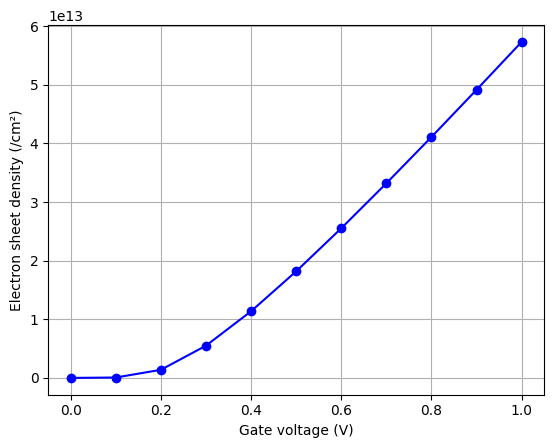

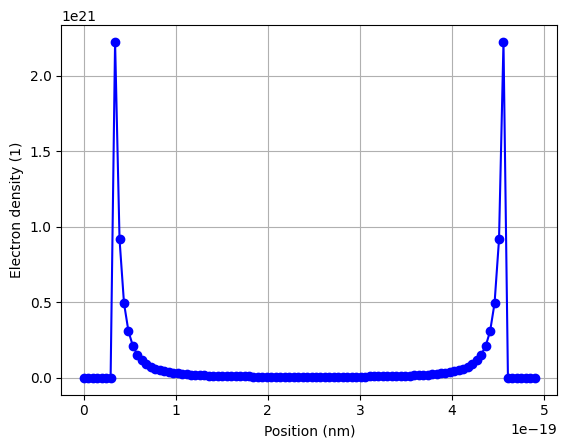

(None, None)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#### Variable ####
t1 = 0.5e-9  # Oxide thickness, m
t2 = 6e-9  # Silicon thickness, m
N = 101
Ndop = -1e18*1e6 # Doping concentration, 1/m^3

# Constants
q = 1.602192e-19
epsilon0 = 8.854187817e-12
nint = 1e16  # Intrinsic carrier concentration (1/cm^3)
kB = 1.38065e-23  # Boltzmann constant (J/K)
T = 300.0  # Temperature (K)
kT = kB * T / q  # Thermal voltage (V)

# Structure length and parameters
a = 2*t1+t2  # Total length (m)
dx = a / (N-1)
iox = round(t1 / dx)
interface1 = iox
interface2 = N - iox
epsilon_si = 11.7
epsilon_ox = 3.9

# Grids
x = np.linspace(0, a, N+1)*dx
phi = np.zeros((N + 1, 1))
hole = np.zeros((N + 1, 1))
elec = np.zeros((N + 1, 1))

QV = np.zeros((11, 2))

for ibias in range(11):
    VG = 0.1 * ibias
    print(f'Gate voltage VG = {VG} V')
    QV[ibias, 0] = VG

    for inewton in range(20):
        A = np.zeros((N + 1, N + 1))
        b = np.zeros((N + 1, 1))

        for ii in range(1, N):
            epsilon_l = epsilon_ox
            epsilon_r = epsilon_ox
            if ii >= interface1 + 1 and ii <= interface2:
                epsilon_l = epsilon_si
            if ii >= interface1 and ii <= interface2 - 1:
                epsilon_r = epsilon_si

            b[ii] = epsilon_r * (phi[ii + 1] - phi[ii]) - epsilon_l * (phi[ii] - phi[ii - 1])
            A[ii, ii - 1] = epsilon_l
            A[ii, ii] = -epsilon_l - epsilon_r
            A[ii, ii + 1] = epsilon_r

        QV[ibias, 1] = 0.0
        for ii in range(interface1, interface2 + 1):
            control = 1.0
            if ii == interface1 or ii == interface2:
                control = 0.5
            hole[ii, 0] = nint * np.exp(-phi[ii, 0] / kT)
            elec[ii, 0] = nint * np.exp(phi[ii, 0] / kT)
            b[ii] = b[ii] + q * (hole[ii, 0] - elec[ii, 0] + Ndop) / epsilon0 * dx * dx * control
            A[ii, ii] = A[ii, ii] - q * (hole[ii, 0] + elec[ii, 0]) / kT/ epsilon0 * dx * dx * control
            QV[ibias, 1] = QV[ibias, 1] + elec[ii, 0] * dx * control

        b[0] = phi[0] - 0.33374 - VG
        A[0, 0] = 1
        b[N] = phi[N] - 0.33374 - VG
        A[N, N] = 1

        update = np.linalg.solve(A, -b)
        phi = phi + update

plt.plot(QV[:, 0], QV[:, 1] / 1e4, 'bo-')
plt.xlabel('Gate voltage (V)'), plt.ylabel('Electron sheet density (/cm²)')
plt.grid(True), plt.show()

plt.plot(x,elec/1e6,'bo-')
plt.xlabel('Position (nm)'), plt.ylabel('Electron density (1)')
plt.grid(True), plt.show()